# Setup

In [1]:
import os
from pathlib import Path
os.chdir(Path.cwd().parent)
# print("cwd is now:", Path.cwd())

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from data_loader import scores_df
from fit import fit_statistical_model
import statsmodels.api as sm
from scipy.stats import linregress
from scipy.stats import gmean
from typing import Union, Optional

null performances after coercion: 281
after saturation filter 2201
after filter num benchmarks 1401
after merge with model versions 1406
after merge with benchmark dates 1406
Original number of rows: 1406
Number of rows after aggregation: 971


In [3]:
anchor_benchmark = "Winogrande"
anchor_difficulty = 0
anchor_slope = 1
# df1, df_cm1, df_db1 = fit_statistical_model(scores_df, anchor_benchmark, anchor_difficulty, anchor_slope)
anchor_mode = "benchmark" # "model", "benchmark"
anchor_benchmark = "Winogrande"
anchor_difficulty = 0
anchor_slope = 1
anchor_model1 = "claude-2.0"
anchor_model1_capability = 1.177630
anchor_model2 = "claude-3-opus-20240229"
anchor_model2_capability = 1.311554

df1, df_cm1, df_db1 = fit_statistical_model(
    scores_df,
    anchor_mode=anchor_mode,
    anchor_benchmark=anchor_benchmark,
    anchor_difficulty=anchor_difficulty,
    anchor_slope=anchor_slope,
    anchor_model1=anchor_model1,
    anchor_model1_capability=anchor_model1_capability,
    anchor_model2=anchor_model2,
    anchor_model2_capability=anchor_model2_capability
)

df_cm1['date_obj'] = pd.to_datetime(df_cm1['date'])

# Convert date strings to datetime objects
df_cm1['date_obj'] = pd.to_datetime(df_cm1['date'])

`ftol` termination condition is satisfied.
Function evaluations 24, initial cost 3.3023e+01, final cost 2.5513e+00, first-order optimality 2.31e-04.


In [4]:
df_cap = df_cm1.copy(deep=True)

# load in data from the pcd
pcd_dataset = pd.read_csv("https://epochai.org/data/epochdb/notable_systems.csv")[["Model", "Training compute (FLOP)", "Parameters", "Training dataset size (datapoints)"]]
columns = {"Training compute (FLOP)": "compute", "Parameters": "parameters", "Training dataset size (datapoints)": "data"}
pcd_dataset = pcd_dataset.rename(columns=columns)

df_cap = df_cap.merge(pcd_dataset, on="Model")
df_cap.columns

Index(['model_id', 'estimated_capability', 'model', 'is_anchor', 'Model',
       'date', 'date_obj', 'compute', 'parameters', 'data'],
      dtype='object')

## Useful functions

In [5]:
# useful functions
# ------------------------------------------------------------------
# 0.  Data prep  ----------------------------------------------------
df = df_cap.copy()

# make sure the columns we’ll need exist and are typed correctly
for col in ["estimated_capability", "date", "compute"]:
    assert col in df.columns, f"missing {col}"
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

def later_lower_compute(
    row: pd.Series,
    df_level: pd.DataFrame,
    cap_tol_below: Union[int, float] = 0.1,
    cap_tol_above: Union[int, float] = 0.1,
) -> pd.DataFrame:
    """
    Return **all** models that are
      • released after ``row["date"]``,
      • use ≤ the same compute, and
      • have capability within ±``cap_tol`` of the current row.

    Parameters
    ----------
    cap_tol : float
        Half-width of the allowed capability band. Default 0.1 means we keep
        models whose capability lies in
        [row[cap_col] - 0.1, row[cap_col] + 0.1].

    Returns
    -------
    pd.DataFrame
        Qualifying later models, sorted by date (may be empty).
    """
    later_mask   = df_level["date"].gt(row["date"])
    compute_mask = df_level["compute"].le(row["compute"])

    lower_bound  = row["estimated_capability"] - cap_tol_below
    upper_bound  = row["estimated_capability"] + cap_tol_above
    cap_mask     = df_level["estimated_capability"].between(lower_bound, upper_bound, inclusive="both")


    later_matches = df_level.loc[later_mask & compute_mask & cap_mask]
    out = pd.concat([row.to_frame().T, later_matches]).sort_values("date")

    return out

# later_lower_compute(df.iloc[16], df, cap_tol=0.1) 16 18 22
# later_lower_compute(df.iloc[22], df, cap_tol_below=0.05, cap_tol_above=0.15)
# for i in range(len(df)):
#   print(i, len(later_lower_compute(df.iloc[i], df, cap_tol_below=0.05, cap_tol_above=2)))

In [6]:
# ------------------------------------------------------------
# Regression + numeric output
# ------------------------------------------------------------
def compute_regression_stats(
    df_slice: pd.DataFrame,
    *,
    date_col: str = "date",
    compute_col: str = "compute",
) -> dict:
    """
    Fit  log10(compute) ~ time  (ordinary least squares).

    Returns
    -------
    dict with keys
        slope_log10              – slope in log10 units per year (should be < 0)
        factor_per_year          – 10**slope (e.g. 0.75 ⇒ 25 % drop/yr)
        pct_reduction_per_year   – (1-factor)*100
        intercept_log10, r_value, p_value, stderr
    """

    df = df_slice.copy()
    # ensure chronological order & datetime dtype
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col)

    # numeric X axis = fractional years since first point
    years = (
        (df[date_col] - df[date_col].iloc[0])
        .dt.total_seconds()
        / (365.25 * 24 * 3600)
    )

    # log-10 transform of compute
    y = np.log10(df[compute_col].astype(float))

    slope, intercept, r, p, se = linregress(years, y)

    factor_per_year        = 10 ** slope          # < 1 if slope negative
    pct_reduction_per_year = (1 - factor_per_year) * 100

    return {
        "slope_log10": slope,
        "intercept_log10": intercept,
        "r_value": r,
        "p_value": p,
        "stderr": se,
        "factor_per_year": 1/factor_per_year,
        "pct_reduction_per_year": pct_reduction_per_year,
    }


# ------------------------------------------------------------
# Plot
# ------------------------------------------------------------
def plot_compute_trend(
    df_slice: pd.DataFrame,
    *,
    date_col: str = "date",
    compute_col: str = "compute",
    title: str | None = None,
    ax: plt.Axes | None = None,
):
    """
    Scatter of compute vs date (log-y) with best-fit line overlaid.
    """
    stats = compute_regression_stats(df_slice, date_col=date_col, compute_col=compute_col)

    df = df_slice.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col)

    # X for plotting
    years = (
        (df[date_col] - df[date_col].iloc[0])
        .dt.total_seconds()
        / (365.25 * 24 * 3600)
    )

    # Fitted line in *linear* compute space
    y_fit_log10 = stats["intercept_log10"] + stats["slope_log10"] * years
    y_fit       = 10 ** y_fit_log10

    if ax is None:
        _, ax = plt.subplots()

    ax.scatter(df[date_col], df[compute_col], label="models")
    ax.plot(df[date_col], y_fit, label="OLS fit", linewidth=2)

    ax.set_yscale("log")
    ax.set_xlabel("Date")
    ax.set_ylabel("Training compute")
    ax.set_title(
        title
        or "Compute trend (≈ constant capability)\n"
           f"≈ {stats['pct_reduction_per_year']:.1f}% less compute per year"
    )
    ax.legend()
    plt.tight_layout()

# Visualization

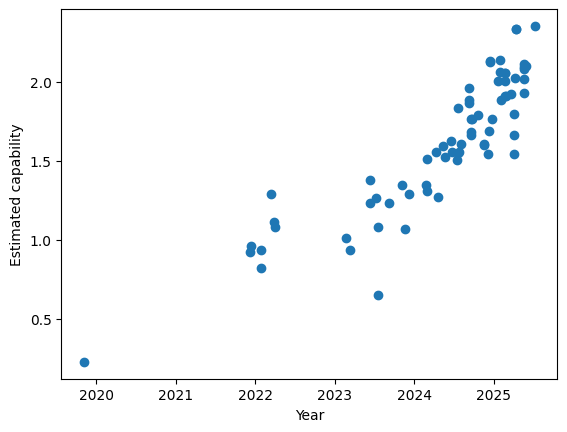

In [7]:
plt.scatter(df_cap["date_obj"], df_cap["estimated_capability"])
# plt.xscale("log")
plt.xlabel("Year")
plt.ylabel("Estimated capability")
plt.show()

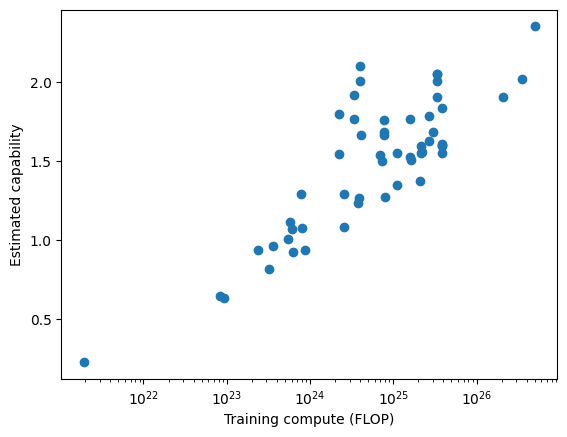

In [8]:
plt.scatter(df_cap["compute"], df_cap["estimated_capability"])
plt.xscale("log")
plt.xlabel("Training compute (FLOP)")
plt.ylabel("Estimated capability")
plt.show()

# Compute requirements reduction

In [11]:
n_min = 10
cap_tol_below = 0.05
cap_tol_above = 99
date_col = "date_obj"
compute_col = "compute"

results = []

for idx, anchor in df.iterrows():
    window = later_lower_compute(anchor, df,
                                  cap_tol_below=cap_tol_below,
                                  cap_tol_above=cap_tol_above)

    if len(window) < n_min:
        # not enough data → skip
        continue

    stats = compute_regression_stats(
        window, date_col=date_col, compute_col=compute_col
    )

    results.append(
        {
            "anchor_idx": idx,
            "anchor_date": anchor[date_col],
            "anchor_model": anchor["model"],
            "n_points": len(window),
            **stats,                     # slope_log10, factor_per_year, …
        }
    )

compute_reduction_df = pd.DataFrame(results)
compute_reduction_df[["anchor_model", "n_points", "factor_per_year", "p_value"]]

,anchor_model,n_points,factor_per_year,p_value
0,gpt-4-0613,18,3.349319,0.000003
1,mistral-large-2402,14,3.680854,0.000035
2,claude-3-opus-20240229,16,4.973034,0.000006
3,gpt-4-turbo-2024-04-09,17,7.019123,0.000024
4,Meta-Llama-3-70B-Instruct,13,3.231071,0.000613
5,gpt-4o-2024-05-13,25,4.554944,0.020407
6,gemini-1.5-pro-001,15,5.365974,0.000034
7,claude-3-5-sonnet-20240620,13,10.265737,0.002200
8,mistral-large-2407,12,4.802658,0.000221
9,Llama-3.1-405B-Instruct,21,5.090366,0.070720


In [10]:
gmean(compute_reduction_df["factor_per_year"])

np.float64(6.3688306938212405)

Annual compute reduction ≈ 92.5% (13.325× per year)


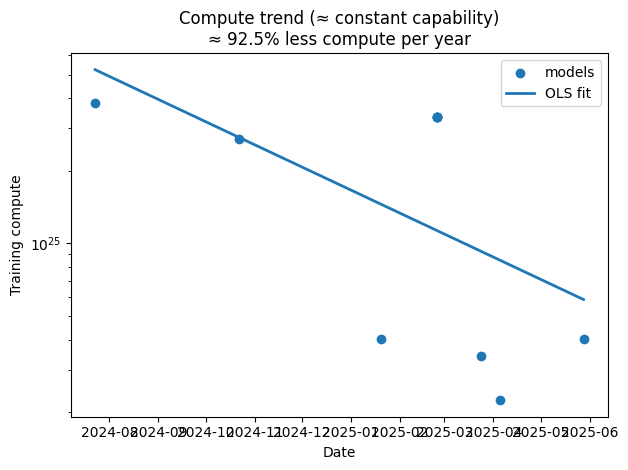

In [12]:
window = later_lower_compute(df.iloc[30], df,
                             cap_tol_below=cap_tol_below, cap_tol_above=cap_tol_above)
stats   = compute_regression_stats(window)
print(f"Annual compute reduction ≈ {stats['pct_reduction_per_year']:.1f}% "
      f"({stats['factor_per_year']:.3f}× per year)")

plot_compute_trend(window)

# Capabilities increase at fixed compute

In [13]:
# ---------------------------------------------------------------
# 0.  Data prep  -------------------------------------------------
df = df_cap.copy() 
for col in ["estimated_capability", "date", "compute"]:
    assert col in df.columns, f"missing {col}"
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")


def later_higher_capability(
    df_level: pd.DataFrame,
    *,
    compute_target: Union[int, float],
    date_from: Union[str, pd.Timestamp],
    compute_tol_below: Union[int, float] = 1.0,
    compute_tol_above: Union[int, float] = 1.0,
    # ―― choose *either* a relative improvement … ―――――――――――――――――――――――――――――
    compare_row: Optional[pd.Series] = None,
    # ―― … or an absolute capability floor (ignored if compare_row is given) ――
    cap_floor: Optional[Union[int, float]] = None,
) -> pd.DataFrame:
    """
    Return **all** models that
      • are released after *date_from*,
      • use ≈ the *compute_target* (|Δ| ≤ compute_tol), **and**
      • beat either:
          – compare_row["estimated_capability"] + min_cap_gain,   if *compare_row* is given, or
          – the absolute level *cap_floor*,                       otherwise.

    Parameters
    ----------
    compute_target : float
        The compute budget you want to hold (roughly) constant.
    compute_tol : float, default 0
        Half-width of the allowed compute band.
        e.g. 0.05 means keep models in [target-0.05, target+0.05].
        Use an absolute value; if you prefer relative %, multiply first.
    date_from : str | pd.Timestamp
        Cut-off date – only later releases are considered.
    compare_row : pd.Series, optional
        If provided we measure “higher capability” relative to this row.
        If omitted we fall back to *cap_floor* (must then be supplied).
    min_cap_gain : float, default 0.1
        The minimum improvement over *compare_row* we insist on.
    cap_floor : float, optional
        Absolute capability threshold if *compare_row* is None.

    Returns
    -------
    pd.DataFrame
        Qualifying later models, sorted by date (may be empty).
    """
    date_from = pd.to_datetime(date_from)

    # later in time ------------------------------------------------
    later_mask = df_level["date"].gt(date_from)

    # roughly equal compute ---------------------------------------
    lower_compute = compute_target / compute_tol_below
    upper_compute = compute_target * compute_tol_above
    compute_mask = df_level["compute"].between(lower_compute, upper_compute, inclusive="both")

    # capability strictly higher ----------------------------------
    if compare_row is not None:
        cap_threshold = compare_row["estimated_capability"]
    elif cap_floor is not None:
        cap_threshold = cap_floor
    else:
        raise ValueError("Supply either compare_row or cap_floor")

    cap_mask = df_level["estimated_capability"].gt(cap_threshold)

    # ----------------------------------------------------------------
    later_better = df_level.loc[later_mask & compute_mask & cap_mask]
    return later_better.sort_values("date")

for i in range(len(df)):
  baseline = df.loc[i]
  window = later_higher_capability(
      df,
      compute_target=baseline["compute"],
      date_from=baseline["date"],
      compare_row=baseline,
      compute_tol_below = 1000,
      compute_tol_above = 1.05
  )
  print(i, len(window))

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 1
12 1
13 1
14 0
15 1
16 1
17 0
18 0
19 0
20 2
21 2
22 0
23 0
24 0
25 7
26 0
27 4
28 2
29 5
30 5
31 5
32 5
33 5
34 1
35 11
36 11
37 17
38 6
39 21
40 11
41 9
42 11
43 20
44 0
45 7
46 13
47 14
48 8
49 19
50 13
51 0
52 0
53 0
54 3
55 12
56 7
57 5
58 0
59 0
60 3
61 1
62 0
63 0
64 0
65 0
66 6
67 5
68 1
69 0
70 0
71 0


In [14]:
baseline = df.loc[30]
window = later_higher_capability(
    df,
    compute_target=baseline["compute"],
    date_from=baseline["date"],
    compare_row=baseline,
    compute_tol_below = 2,
    compute_tol_above = 1.05
)
window

,model_id,estimated_capability,model,is_anchor,Model,date,date_obj,compute,parameters,data
15,m71,2.006100,DeepSeek-R1,False,DeepSeek-R1,2025-01-20,2025-01-20,4.020010e+24,6.710000e+11,NaN
7,m74,2.101163,DeepSeek-R1-0528,False,DeepSeek-R1,2025-05-28,2025-05-28,4.020010e+24,6.710000e+11,NaN


In [15]:
import numpy as np
import pandas as pd
from scipy.stats import linregress
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1 A.  Regression stats
# ------------------------------------------------------------
def capability_regression_stats(
    df_slice: pd.DataFrame,
    *,
    date_col: str = "date",
    cap_col: str = "estimated_capability",
) -> dict:
    """
    Fit  capability ~ time  (ordinary least squares).

    Returns
    -------
    dict with keys
        slope_per_year            – capability units gained per year
        intercept, r_value, p_value, stderr
    """
    df = df_slice.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col)

    # numeric X axis = fractional years since first point
    years = (
        (df[date_col] - df[date_col].iloc[0])
        .dt.total_seconds()
        / (365.25 * 24 * 3600)
    )

    y = df[cap_col].astype(float)

    slope, intercept, r, p, se = linregress(years, y)

    return {
        "slope_per_year": slope,
        "intercept": intercept,
        "r_value": r,
        "p_value": p,
        "stderr": se,
    }

# ------------------------------------------------------------
# 1 B.  Plot capability trend
# ------------------------------------------------------------
def plot_capability_trend(
    df_slice: pd.DataFrame,
    *,
    date_col: str = "date",
    cap_col: str = "estimated_capability",
    title: str | None = None,
    ax: plt.Axes | None = None,
):
    """
    Scatter of capability vs date (linear y) with best-fit line.
    """
    stats = capability_regression_stats(df_slice, date_col=date_col, cap_col=cap_col)

    df = df_slice.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col)

    years = (
        (df[date_col] - df[date_col].iloc[0])
        .dt.total_seconds()
        / (365.25 * 24 * 3600)
    )
    y_fit = stats["intercept"] + stats["slope_per_year"] * years

    if ax is None:
        _, ax = plt.subplots()

    ax.scatter(df[date_col], df[cap_col], label="models")
    ax.plot(df[date_col], y_fit, label="OLS fit", linewidth=2)

    ax.set_xlabel("Date")
    ax.set_ylabel("Estimated capability")
    ax.set_title(
        title
        or "Capability trend (≈ constant compute)\n"
           f"≈ {stats['slope_per_year']:.3f} capability units gained per year"
    )
    ax.legend()
    plt.tight_layout()

# ------------------------------------------------------------
# 2.  Iterate over anchors, build summary table
# ------------------------------------------------------------
n_min = 5                       # require ≥ this many points in a window
compute_tol_below = 1e5
compute_tol_above = 1.05

results = []

for idx, anchor in df.iterrows():
    window = later_higher_capability(
        df,
        compute_target=anchor["compute"],
        date_from=anchor["date"],
        compare_row=anchor,
        compute_tol_below=compute_tol_below,
        compute_tol_above=compute_tol_above,
    )

    if len(window) < n_min:
        continue        # not enough data → skip

    stats = capability_regression_stats(window)

    results.append(
        {
            "anchor_idx": idx,
            "anchor_model": anchor["model"],
            "anchor_date": anchor["date"],
            "n_points": len(window),
            **stats,                         # slope_per_year, r_value, …
        }
    )

summary_df = pd.DataFrame(results)
summary_df

,anchor_idx,anchor_model,anchor_date,n_points,slope_per_year,intercept,r_value,p_value,stderr
0,67,Gopher (280B),2021-12-08,5,0.005570,1.013449,0.059200,0.924668,0.054221
1,66,Megatron-Turing NLG 530B,2022-01-28,6,0.059174,1.019145,0.310899,0.548677,0.090450
2,49,gpt-4-0613,2023-06-13,19,0.314933,1.477607,0.655692,0.002304,0.087954
3,56,claude-2.0,2023-07-11,7,0.432163,1.309887,0.764632,0.045263,0.162896
4,57,falcon-180B,2023-09-06,5,0.353699,1.312681,0.805700,0.099761,0.150127
5,50,mistral-large-2402,2024-02-26,13,0.346898,1.562142,0.567549,0.043062,0.151733
6,47,claude-3-opus-20240229,2024-02-29,14,0.308307,1.567085,0.551455,0.040934,0.134634
7,40,gpt-4-turbo-2024-04-09,2024-04-09,11,0.354136,1.694481,0.592140,0.054941,0.160646
8,55,Meta-Llama-3-70B-Instruct,2024-04-18,12,0.342017,1.587861,0.512864,0.088179,0.181039
9,39,gpt-4o-2024-05-13,2024-05-13,21,0.397137,1.615133,0.636035,0.001940,0.110537


In [ ]:
s = summary_df["slope_per_year"].dropna().to_numpy()
positive = s[s > 0]
geo_mean = gmean(positive) if positive.size else np.nan
geo_mean


np.float64(0.2857660660845251)

In [22]:
np.mean(summary_df["slope_per_year"])

np.float64(0.34464436479856053)

5


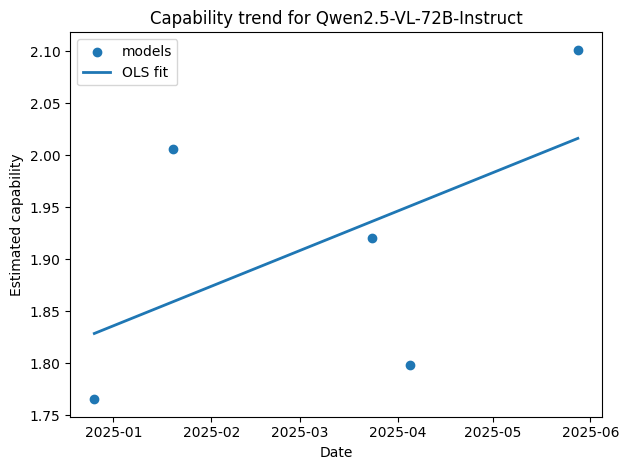

In [18]:
baseline = df.loc[30]
window = later_higher_capability(
    df,
    compute_target=baseline["compute"],
    date_from=baseline["date"],
    compare_row=baseline,
    compute_tol_below=1000,
    compute_tol_above=1.05,
)

print(len(window))

plot_capability_trend(window, title=f"Capability trend for {baseline['model']}")